In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f053950a33b0b13c6e5650782e5380f49c46d434995c98d24a1a18c73fa27839
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("YelpDataAnalysis").getOrCreate()

yelp_df = spark.read.option("header", "true").csv('/content/sample_data/yelp_user.csv', inferSchema=True)

# Convert DataFrame to RDD
yelp_rdd = yelp_df.rdd

filtered_rdd = yelp_rdd.zipWithIndex().filter(lambda x: x[1] > 0).map(lambda x: x[0])

# Show the first few rows of the RDD
for row in filtered_rdd.take(5):
    print(row)

Row(user_id='uUzsFQn_6cXDh6rPNGbIFA', name='Tiffy', review_count=1, yelping_since=datetime.date(2017, 3, 2), friends='None', useful=0, funny=0, cool=0, fans=0, elite='None', average_stars=2.0, compliment_hot=0, compliment_more=0, compliment_profile=0, compliment_cute=0, compliment_list=0, compliment_note=0, compliment_plain=0, compliment_cool=0, compliment_funny=0, compliment_writer=0, compliment_photos=0)
Row(user_id='mBneaEEH5EMyxaVyqS-72A', name='Mark', review_count=6, yelping_since=datetime.date(2015, 3, 13), friends='None', useful=0, funny=0, cool=0, fans=0, elite='None', average_stars=4.67, compliment_hot=0, compliment_more=0, compliment_profile=0, compliment_cute=0, compliment_list=0, compliment_note=0, compliment_plain=0, compliment_cool=0, compliment_funny=0, compliment_writer=0, compliment_photos=0)
Row(user_id='W5mJGs-dcDWRGEhAzUYtoA', name='Evelyn', review_count=3, yelping_since=datetime.date(2016, 9, 8), friends='None', useful=0, funny=0, cool=0, fans=0, elite='None', aver

In [ ]:
yelp_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- yelping_since: date (nullable = true)
 |-- friends: string (nullable = true)
 |-- useful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- cool: integer (nullable = true)
 |-- fans: integer (nullable = true)
 |-- elite: string (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- compliment_hot: integer (nullable = true)
 |-- compliment_more: integer (nullable = true)
 |-- compliment_profile: integer (nullable = true)
 |-- compliment_cute: integer (nullable = true)
 |-- compliment_list: integer (nullable = true)
 |-- compliment_note: integer (nullable = true)
 |-- compliment_plain: integer (nullable = true)
 |-- compliment_cool: integer (nullable = true)
 |-- compliment_funny: integer (nullable = true)
 |-- compliment_writer: integer (nullable = true)
 |-- compliment_photos: integer (nullable = true)



In [ ]:
from pyspark.sql.functions import col
from pyspark.mllib.stat import Statistics


In [ ]:
correlation = yelp_df.stat.corr("review_count", "average_stars")

print(f"The Pearson correlation coefficient between review_count and average_stars is: {correlation}")

The Pearson correlation coefficient between review_count and average_stars is: 0.014008480321383483


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql import functions as F
from pyspark.sql.functions import year, to_timestamp
import datetime

unique_rdd = filtered_rdd.distinct()

def activity_level(review_count):
    if review_count <= 10:
        return 'Low'
    elif review_count <= 50:
        return 'Medium'
    elif review_count <= 100:
        return 'High'
    else:
        return 'Very High'


# Adjust map function to handle date correctly
def map_func(row):
    activity_lvl = activity_level(row.review_count)
    yelping_since_year = row.yelping_since.year if row.yelping_since and hasattr(row.yelping_since, 'year') else None
    current_year = datetime.datetime.now().year
    years_active = current_year - yelping_since_year if yelping_since_year else None
    return (activity_lvl, 1, years_active)

transformed_rdd = unique_rdd.map(map_func)

# Reduce by key to calculate distribution of activity levels and average years active
def reduce_func(x, y):
    return (x[0] + y[0], x[1] + y[1])

activity_distribution_rdd = transformed_rdd.map(lambda x: (x[0], x[1])).reduceByKey(lambda x, y: x + y)
average_years_active_rdd = transformed_rdd.filter(lambda x: x[2] is not None).map(lambda x: (x[0], (x[2], 1))).reduceByKey(reduce_func).map(lambda x: (x[0], x[1][0] / x[1][1]))

# Collect results to the driver to show them
print("Activity Distribution:")
for result in activity_distribution_rdd.collect():
    print(result)

print("Average Years Active:")
for result in average_years_active_rdd.collect():
    print(result)


Activity Distribution:
('Low', 45612)
('Medium', 15751)
('High', 3248)
('Very High', 3526)
Average Years Active:
('Low', 10.010611242655441)
('Medium', 12.026728461684973)
('High', 13.12192118226601)
('Very High', 13.881452070334657)


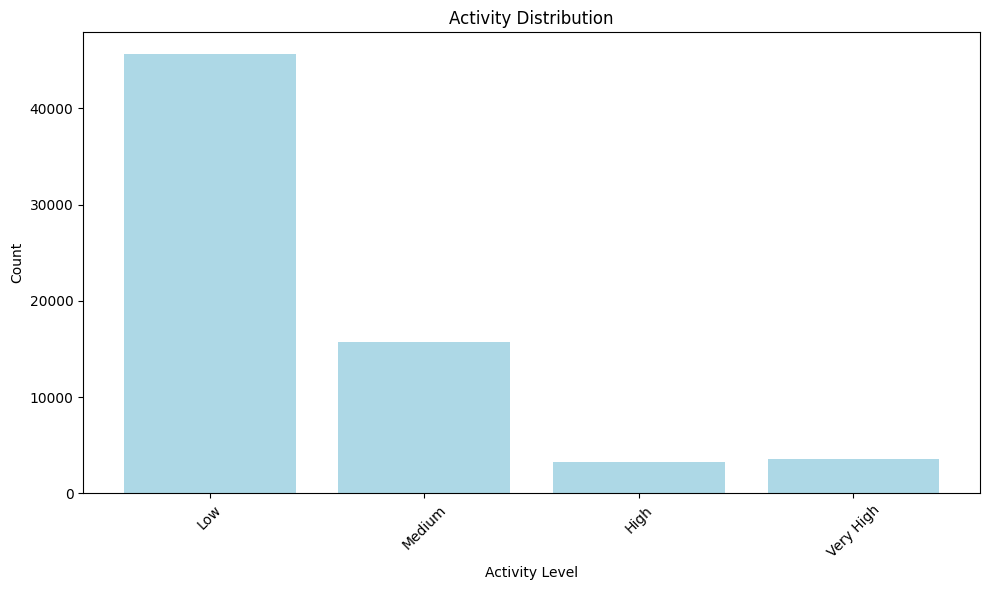

In [4]:
import matplotlib.pyplot as plt

activity_distribution_data = activity_distribution_rdd.collect()
average_years_active_data = average_years_active_rdd.collect()

desired_order = ['Low', 'Medium', 'High', 'Very High']

# Sort the data according to the desired order
sorted_activity_distribution_data = sorted(activity_distribution_data, key=lambda x: desired_order.index(x[0]))

# Extract the sorted activity levels and counts
activity_levels = [x[0] for x in sorted_activity_distribution_data]
counts = [x[1] for x in sorted_activity_distribution_data]

# Visualization of Activity Distribution
plt.figure(figsize=(10, 6))
plt.bar(activity_levels, counts, color='lightblue')
plt.xlabel('Activity Level')
plt.ylabel('Count')
plt.title('Activity Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


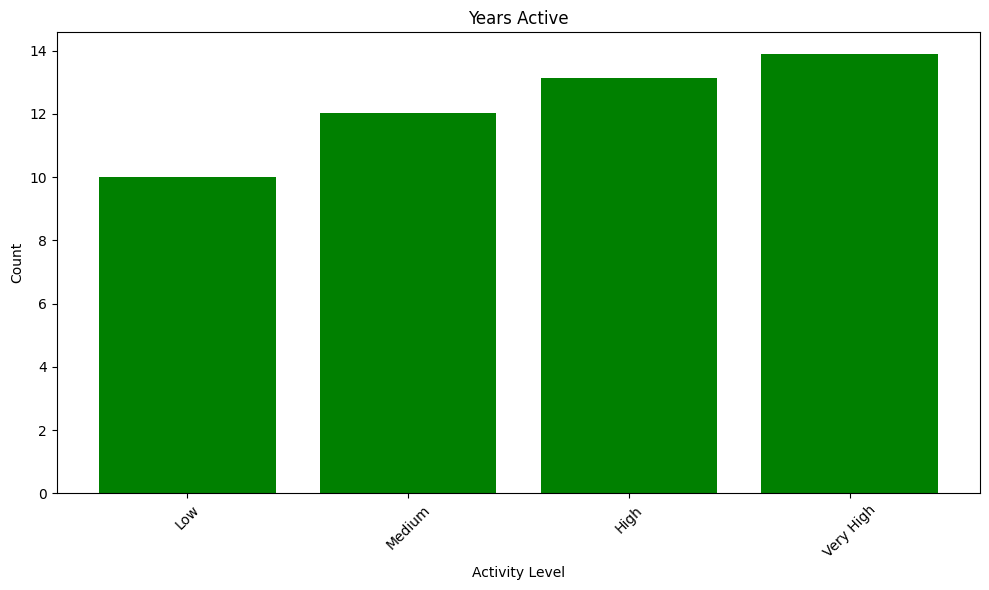

In [5]:

sorted_distribution_data = sorted(average_years_active_data, key=lambda x: desired_order.index(x[0]))

# Extract the sorted activity levels and counts
year_ls = [x[0] for x in sorted_distribution_data]
counts = [x[1] for x in sorted_distribution_data]

# Visualization of Activity Distribution
plt.figure(figsize=(10, 6))
plt.bar(activity_levels, counts, color='green')
plt.xlabel('Activity Level')
plt.ylabel('Count')
plt.title('Years Active')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


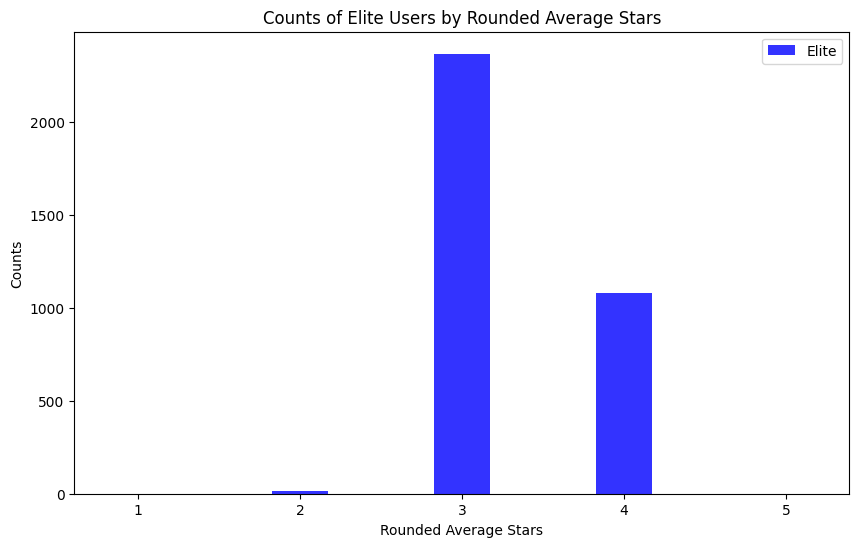

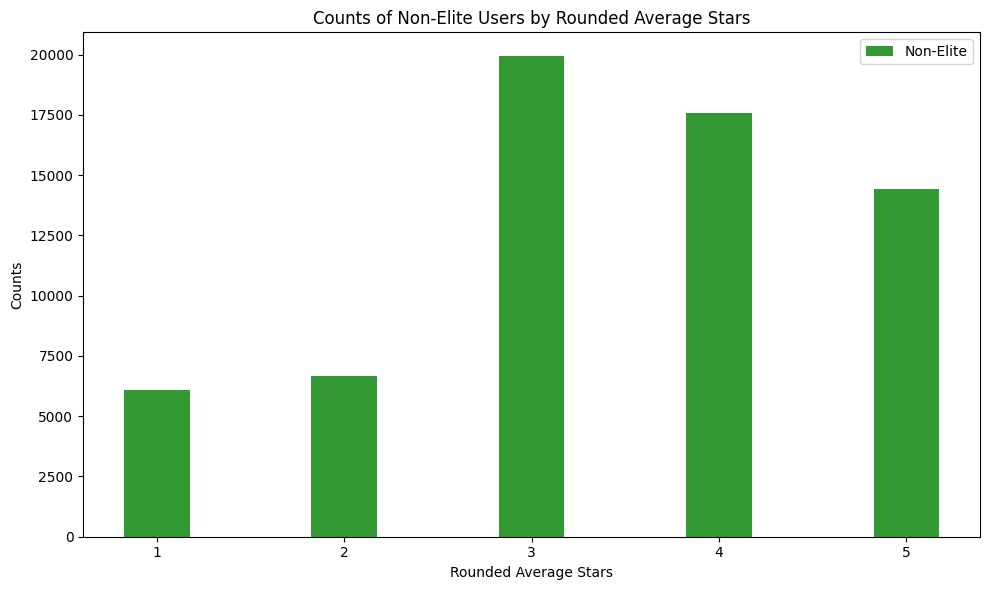

In [6]:

def process_row(row):
    try:
        rounded_average_stars = int(row.average_stars) if row.average_stars is not None else None
        if rounded_average_stars is None:
            return None
        is_elite = 1 if row.elite != "None" else 0
        is_not_elite = 1 if row.elite == "None" else 0
        return (rounded_average_stars, (is_elite, is_not_elite))
    except Exception:
        return None

pair_rdd = unique_rdd.map(process_row).filter(lambda x: x is not None)

def reduce_counts(a, b):
    return (a[0] + b[0], a[1] + b[1])

counts_rdd = pair_rdd.reduceByKey(reduce_counts)

results = counts_rdd.collect()

sorted_results = sorted(results)

categories, counts = zip(*sorted_results)
elite_counts, non_elite_counts = zip(*counts)

# Plot for Elite Users
fig, ax1 = plt.subplots(figsize=(10, 6))
index = range(len(categories))
bar_width = 0.35
opacity = 0.8

rects1 = ax1.bar(index, elite_counts, bar_width,
                 alpha=opacity, color='b', label='Elite')

ax1.set_xlabel('Rounded Average Stars')
ax1.set_ylabel('Counts')
ax1.set_title('Counts of Elite Users by Rounded Average Stars')
ax1.set_xticks(index)
ax1.set_xticklabels(categories)
ax1.legend()

# Plot for Non-Elite Users
fig, ax2 = plt.subplots(figsize=(10, 6))
rects2 = ax2.bar(index, non_elite_counts, bar_width,
                 alpha=opacity, color='g', label='Non-Elite')

ax2.set_xlabel('Rounded Average Stars')
ax2.set_ylabel('Counts')
ax2.set_title('Counts of Non-Elite Users by Rounded Average Stars')
ax2.set_xticks(index)
ax2.set_xticklabels(categories)
ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql.functions import col, floor
from pyspark.sql.window import Window
from pyspark.sql.functions import rank


def map_star_reviews(row):
    if row.average_stars is not None:
        adjusted_average_stars = int(row.average_stars)
        return (adjusted_average_stars, (row.review_count, row.name))
    return None

mapped_rdd = unique_rdd.map(map_star_reviews).filter(lambda x: x is not None)

def reduce_top_user(a, b):
    return a if a[0] > b[0] else b

top_users_rdd = mapped_rdd.reduceByKey(reduce_top_user)

# Collect and print results
top_users = top_users_rdd.collect()
print("Top user(s) per star category based on review count:")
for category, (count, name) in top_users:
    print(f"Star Category: {category}, User: {name}, Review Count: {count}")


Top user(s) per star category based on review count:
Star Category: 4, User: Jennifer, Review Count: 3906
Star Category: 5, User: Markus, Review Count: 539
Star Category: 1, User: Henry, Review Count: 248
Star Category: 2, User: Daniel, Review Count: 1307
Star Category: 3, User: Bruce, Review Count: 8353


In [7]:
def process_row(row):
    try:
        rounded_average_stars = int(row.average_stars) if row.average_stars is not None else None
        if rounded_average_stars is None:
            return None
        is_elite = 1 if row.elite != "None" else 0
        is_not_elite = 1 if row.elite == "None" else 0
        return (rounded_average_stars, (is_elite, is_not_elite))
    except Exception as e:
        print(f"Error processing row {row}: {e}")
        return None

pair_rdd = unique_rdd.map(process_row).filter(lambda x: x is not None)

def reduce_counts(a, b):
    return (a[0] + b[0], a[1] + b[1])

counts_rdd = pair_rdd.reduceByKey(reduce_counts)

results = counts_rdd.collect()
print("Elite and Non-Elite User Counts by Rounded Average Stars:")
for key, value in sorted(results):
    print(f"Rounded Average Stars: {key}, Elite User Count: {value[0]}, Non-Elite User Count: {value[1]}")


Elite and Non-Elite User Counts by Rounded Average Stars:
Rounded Average Stars: 1, Elite User Count: 0, Non-Elite User Count: 6093
Rounded Average Stars: 2, Elite User Count: 16, Non-Elite User Count: 6663
Rounded Average Stars: 3, Elite User Count: 2366, Non-Elite User Count: 19928
Rounded Average Stars: 4, Elite User Count: 1080, Non-Elite User Count: 17559
Rounded Average Stars: 5, Elite User Count: 1, Non-Elite User Count: 14431


In [8]:
from pyspark.sql.functions import round, col, avg

yelp_df=yelp_df.distinct()

yelp_df = yelp_df.filter(yelp_df['average_stars'].isNotNull()).distinct()

df_with_rounded_stars = yelp_df.withColumn('rounded_average_stars', round('average_stars').cast('integer'))

averages_df = df_with_rounded_stars.groupBy('rounded_average_stars').agg(
    avg('cool').alias('avg_cool'),
    avg('useful').alias('avg_useful'),
    avg('funny').alias('avg_funny')
)

sorted_averages_df = averages_df.orderBy('rounded_average_stars')

sorted_averages_df.show()


+---------------------+-------------------+------------------+------------------+
|rounded_average_stars|           avg_cool|        avg_useful|         avg_funny|
+---------------------+-------------------+------------------+------------------+
|                    1|0.10789422891333719|0.7510133178922987|0.1325998841922409|
|                    2| 0.5381325730577334| 4.191732002851033|1.1423140888572108|
|                    3| 10.190176031977861| 20.13728956876009| 9.170727957567838|
|                    4|  45.68449781659389| 63.62156893325015| 31.26520586400499|
|                    5|  4.249166293365189| 3.102981434473147|1.1057189786471555|
+---------------------+-------------------+------------------+------------------+



In [ ]:
# List of metrics to correlate
metrics = ['cool', 'useful', 'funny']

# Initialize an empty dictionary to hold correlation values
correlation_matrix = {}

# Calculate correlations
for x in metrics:
    for y in metrics:
        correlation_matrix[(x, y)] = yelp_df.stat.corr(x, y)

# Display the correlation matrix
for keys, value in correlation_matrix.items():
    print(f"Correlation between {keys[0]} and {keys[1]}: {value}")


Correlation between cool and cool: 1.0
Correlation between cool and useful: 0.9489749153789331
Correlation between cool and funny: 0.863714460831059
Correlation between useful and cool: 0.9489749153789331
Correlation between useful and useful: 1.0
Correlation between useful and funny: 0.8506269579876585
Correlation between funny and cool: 0.863714460831059
Correlation between funny and useful: 0.8506269579876585
Correlation between funny and funny: 1.0


Another Dataset.

Analysis on different categories of restaurent and recommendation for different categories

In [9]:
yelp_businessdf = spark.read.csv('/content/sample_data/yelp_business.csv', header=True, inferSchema=True)


In [10]:
yelp_businessdf = yelp_businessdf.dropDuplicates()
yelp_businessdf = yelp_businessdf.dropna(how='any')


# Show the first few rows of the DataFrame
yelp_businessdf.show()


+--------------------+--------------------+---------------+--------------------+-----------+---------+-----------+-------------+--------------+------------+------------+-------+--------------------+
|         business_id|                name|   neighborhood|             address|       city|    state|postal_code|     latitude|     longitude|       stars|review_count|is_open|          categories|
+--------------------+--------------------+---------------+--------------------+-----------+---------+-----------+-------------+--------------+------------+------------+-------+--------------------+
|Toekt2MQGNDowTc4a...|"""Nevada Imaging...|  Spring Valley|"""5495 S Rainbow...|  Las Vegas|       NV|      89118|   36.0890355|  -115.2433613|         2.5|           9|    1.0|Diagnostic Imagin...|
|eSQt_QNjxNEYN3bF1...|  """Monster Mash"""|       Old Town|"""20 Forrest Roa...|  Edinburgh|      EDH|    EH1 2QN|      55.9458|       -3.1911|         3.5|          25|    0.0|British;Cafes;Res...|
|Dkli

In [11]:
from pyspark.sql.functions import regexp_replace, col

business = yelp_businessdf.drop('neighborhood')

business = business.withColumn('name', regexp_replace(col('name'), '"', ''))
business = business.withColumn('address', regexp_replace(col('address'), '"', ''))

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
usa = business.filter(col('state').isin(states))


In [12]:


# To show the first few rows of the DataFrame
usa.show()


+--------------------+--------------------+--------------------+----------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|         business_id|                name|             address|      city|state|postal_code|     latitude|     longitude|stars|review_count|is_open|          categories|
+--------------------+--------------------+--------------------+----------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|Toekt2MQGNDowTc4a...|Nevada Imaging Ce...| 5495 S Rainbow Blvd| Las Vegas|   NV|      89118|   36.0890355|  -115.2433613|  2.5|           9|    1.0|Diagnostic Imagin...|
|fVGRwzBFz8LMRPV2g...|      Millenium Foto|3475 Las Vegas Bl...| Las Vegas|   NV|      89109|   36.1193098|  -115.1717702|  2.5|           3|    1.0|Shopping;Photogra...|
|FB50TrfcJOHAL7a0J...|       31KreationsLV| 3231 N Decatur Blvd| Las Vegas|   NV|      89130|36.2179958802|-115.208014618|  2.5|           3|    

In [13]:
from pyspark.sql.functions import when, col

us_restaurants = usa.filter(usa['categories'].contains('Restaurants'))

cuisine_mapping = when(col("categories").contains("American"), "American") \
    .when(col("categories").contains("Mexican"), "Mexican") \
    .when(col("categories").contains("Italian"), "Italian") \
    .when(col("categories").contains("Japanese"), "Japanese") \
    .when(col("categories").contains("Chinese"), "Chinese") \
    .when(col("categories").contains("Thai"), "Thai") \
    .when(col("categories").contains("Mediterranean"), "Mediterranean") \
    .when(col("categories").contains("French"), "French") \
    .when(col("categories").contains("Vietnamese"), "Vietnamese") \
    .when(col("categories").contains("Greek"), "Greek") \
    .when(col("categories").contains("Indian"), "Indian") \
    .when(col("categories").contains("Korean"), "Korean") \
    .when(col("categories").contains("Hawaiian"), "Hawaiian") \
    .when(col("categories").contains("African"), "African") \
    .when(col("categories").contains("Spanish"), "Spanish") \
    .when(col("categories").contains("Middle Eastern"), "Middle Eastern") \
    .otherwise("Other")

us_restaurants = us_restaurants.withColumn("category", cuisine_mapping)


In [ ]:

us_restaurants.select("category").show()


+-------------+
|     category|
+-------------+
|      Chinese|
|      Chinese|
|     Japanese|
|     American|
|     American|
|      Italian|
|        Other|
|     American|
|     American|
|        Other|
|     American|
|     American|
|         Thai|
|        Other|
|Mediterranean|
|     American|
|        Other|
|       Indian|
|     American|
|      Italian|
+-------------+
only showing top 20 rows



In [14]:
us_restaurants = us_restaurants.dropna(subset=['category'])


In [15]:
us_restaurants = us_restaurants.drop('categories')


In [16]:
us_restaurants = us_restaurants.dropDuplicates(['business_id'])

duplicates_count = us_restaurants.groupBy("business_id").count().filter("count > 1").count()

print(f"Number of duplicated business_id entries: {duplicates_count}")


Number of duplicated business_id entries: 0


In [17]:
# Show the first 10 rows
us_restaurants.show(10)

row_count = us_restaurants.count()
col_count = len(us_restaurants.columns)

print(f"DataFrame shape: {row_count} rows, {col_count} columns")


+--------------------+--------------------+--------------------+----------+-----+-----------+-------------+--------------+-----+------------+-------+--------+
|         business_id|                name|             address|      city|state|postal_code|     latitude|     longitude|stars|review_count|is_open|category|
+--------------------+--------------------+--------------------+----------+-----+-----------+-------------+--------------+-----+------------+-------+--------+
|--9e1ONYQuAa-CB_R...|Delmonico Steakhouse|3355 Las Vegas Bl...| Las Vegas|   NV|      89109|    36.123183|    -115.16919|  4.0|        1451|    1.0|   Other|
|--FBCX-N37CMYDfs7...|The Bar At Bermud...|    11624 Bermuda Rd| Henderson|   NV|      89052|   35.9786886|  -115.1550159|  3.5|         108|    1.0|American|
|--cZ6Hhc9F7VkKXxH...|             Pio Pio|         1408 E Blvd| Charlotte|   NC|      28203|35.1998528426|-80.8448199047|  4.0|         317|    1.0|American|
|--q7kSBRb0vWC8lSk...|Double Play Sport...|949

In [18]:
from pyspark.sql.functions import col, count, when, isnan

# Counting nulls and NaNs in each column
null_counts = us_restaurants.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in us_restaurants.columns])

null_counts.show()


+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+-------+--------+
|business_id|name|address|city|state|postal_code|latitude|longitude|stars|review_count|is_open|category|
+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+-------+--------+
|          0|   0|      0|   0|    0|          0|       0|        0|    0|           0|      0|       0|
+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+-------+--------+



In [19]:
from pyspark.sql.functions import desc

category_counts = us_restaurants.groupBy("category").count().orderBy(desc("count"))
category_counts_data = category_counts.collect()

categories = [row['category'] for row in category_counts_data]
counts = [row['count'] for row in category_counts_data]


In [20]:
data = list(zip(categories, counts))
columns = ['Category', 'Number of Restaurants']
df = spark.createDataFrame(data, schema=columns)



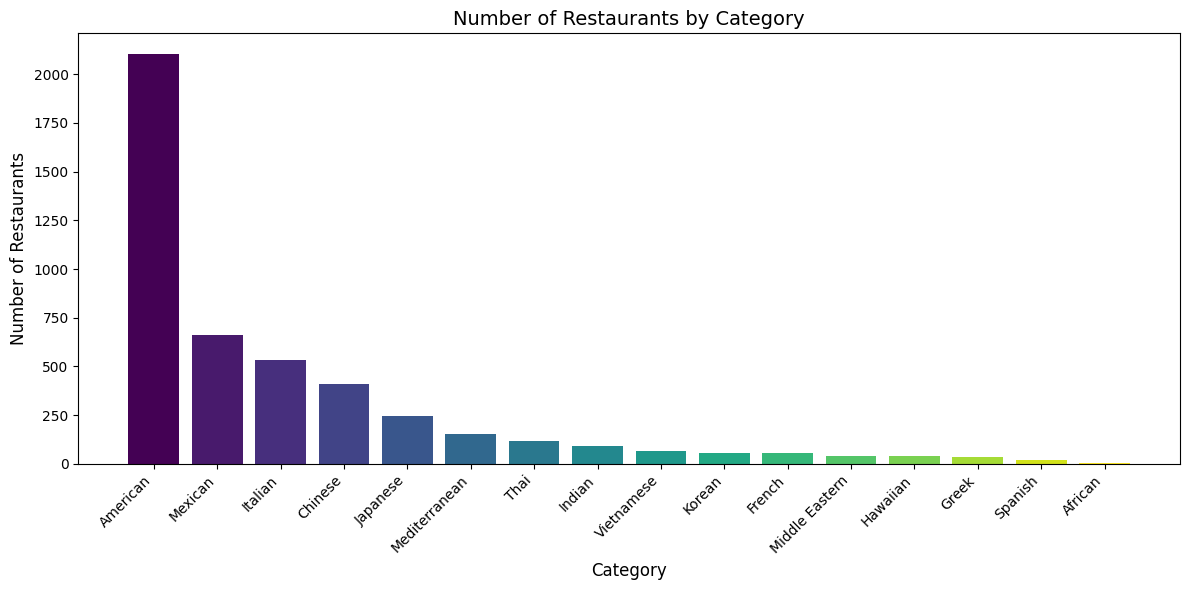

In [21]:
filtered_df = df.filter(df.Category != "Other")
category_data = filtered_df.select("Category").rdd.flatMap(lambda x: x).collect()
count_data = filtered_df.select("Number of Restaurants").rdd.flatMap(lambda x: x).collect()

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors


colors = plt.cm.viridis(np.linspace(0, 1, len(category_data)))

plt.figure(figsize=(12, 6))

plt.bar(category_data, count_data, color=colors)

plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Restaurants', fontsize=12)
plt.title('Number of Restaurants by Category', fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


In [22]:
filtered_df.show()

+--------------+---------------------+
|      Category|Number of Restaurants|
+--------------+---------------------+
|      American|                 2104|
|       Mexican|                  659|
|       Italian|                  532|
|       Chinese|                  410|
|      Japanese|                  244|
| Mediterranean|                  154|
|          Thai|                  116|
|        Indian|                   91|
|    Vietnamese|                   67|
|        Korean|                   56|
|        French|                   56|
|Middle Eastern|                   43|
|      Hawaiian|                   39|
|         Greek|                   36|
|       Spanish|                   18|
|       African|                    6|
+--------------+---------------------+



In [23]:
from pyspark.sql.functions import desc

city_counts = us_restaurants.groupBy("city").count().orderBy(desc("count"))
state_counts = us_restaurants.groupBy("state").count().orderBy(desc("count"))


# Select the top 10 cities
top_10_cities = city_counts.limit(5)
top_10_states = state_counts.limit(5)

top_10_cities.show()
top_10_states.show()

+----------+-----+
|      city|count|
+----------+-----+
| Las Vegas| 3232|
|Pittsburgh| 1489|
| Charlotte| 1266|
| Cleveland|  893|
|   Madison|  714|
+----------+-----+

+-----+-----+
|state|count|
+-----+-----+
|   NV| 3377|
|   PA| 1639|
|   NC| 1271|
|   OH|  929|
|   WI|  723|
+-----+-----+



need to upload dataset in drive

In [24]:
yelp_reviews_cleaned_df = spark.read.csv('/content/drive/MyDrive/sai/yelp_review.csv', header=True)


In [25]:
yelp_reviews_cleaned_df.printSchema()


root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)



In [26]:
yelp_reviews_cleaned_df.show()


+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|  NULL| NULL|NULL|
|Staff was very he...|                   0|                   0|    0|      NULL|                NULL|  NULL| NULL|NULL|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|  NULL| NULL|NULL|
|We had their beef...|                NULL|                NULL| NULL|      NULL|                NULL|  NULL| NULL|NULL|
|A bit outside of ...|                   0|                   0|    0|      NULL|                NULL|  NULL| NULL|NULL|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5

In [27]:
review = yelp_reviews_cleaned_df.where(col("date").isNotNull())
review =yelp_reviews_cleaned_df.where(col("text").isNotNull())


In [28]:
review.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|  NULL| NULL|NULL|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|  NULL| NULL|NULL|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|  NULL| NULL|NULL|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|  NULL| NULL|NULL|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|2016-05-28|Had their chocola...|  NULL| NULL|NULL|
|HRPm3vEZ_F-33TYVT...|_4iMDXbXZ1

In [29]:
from pyspark.sql.functions import col, length, regexp_replace, size, split

us_restaurants1 = us_restaurants.withColumnRenamed("stars", "avg_star")


us_restaurants_categories = us_restaurants1.select("business_id", "category","avg_star")

# Join the DataFrames
restaurants_reviews = us_restaurants_categories.join(review, "business_id")



In [30]:
restaurants_reviews.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- category: string (nullable = false)
 |-- avg_star: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)



In [ ]:
yelp_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- yelping_since: date (nullable = true)
 |-- friends: string (nullable = true)
 |-- useful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- cool: integer (nullable = true)
 |-- fans: integer (nullable = true)
 |-- elite: string (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- compliment_hot: integer (nullable = true)
 |-- compliment_more: integer (nullable = true)
 |-- compliment_profile: integer (nullable = true)
 |-- compliment_cute: integer (nullable = true)
 |-- compliment_list: integer (nullable = true)
 |-- compliment_note: integer (nullable = true)
 |-- compliment_plain: integer (nullable = true)
 |-- compliment_cool: integer (nullable = true)
 |-- compliment_funny: integer (nullable = true)
 |-- compliment_writer: integer (nullable = true)
 |-- compliment_photos: integer (nullable = true)



In [31]:
from pyspark.sql.functions import col, when
yelp_df = yelp_df.withColumn("is_elite", when(col("elite") != "None", 1).otherwise(0))
yelp_df = yelp_df.withColumn("is_not_elite", when(col("elite") == "None", 1).otherwise(0))

yelp_df_selected = yelp_df.select("user_id", "is_elite", "is_not_elite")

restaurants_reviews_final = restaurants_reviews.join(yelp_df_selected, "user_id")



In [ ]:
restaurants_reviews_final.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- category: string (nullable = false)
 |-- avg_star: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)
 |-- is_elite: integer (nullable = false)
 |-- is_not_elite: integer (nullable = false)



In [32]:
non_elite_users_df = restaurants_reviews_final.filter(col("is_not_elite") == 1)


In [33]:
!pip install textblob


In [34]:
import nltk
nltk.download('popular')


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [38]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

from pyspark.ml import Pipeline

from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF


# Tokenize text
tokenizer = Tokenizer(inputCol="text", outputCol="words")

# Remove stop words
stopWordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# Hashing TF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures")

# IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Build pipeline
pipeline = Pipeline(stages=[tokenizer, stopWordsRemover, hashingTF, idf])

# Fit pipeline to data
model = pipeline.fit(non_elite_users_df)

# Transform data
result = model.transform(non_elite_users_df)

# Show results
result.select("filtered_words", "features").show(truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
result.show(2)

+--------------------+--------------------+--------+--------+--------------------+-----+----------+--------------------+------+-----+----+--------+------------+--------------------+--------------------+--------------------+--------------------+
|             user_id|         business_id|category|avg_star|           review_id|stars|      date|                text|useful|funny|cool|is_elite|is_not_elite|               words|      filtered_words|         rawFeatures|            features|
+--------------------+--------------------+--------+--------+--------------------+-----+----------+--------------------+------+-----+----+--------+------------+--------------------+--------------------+--------------------+--------------------+
|ssuXFjkH4neiBgwv-...|0Rni7ocMC_Lg2UH0l...| Italian|     3.5|DbLUpPT61ykLTakkn...|    1|2014-08-09|This place is alw...|     6|    0|   0|       0|           1|[this, place, is,...|[place, always, d...|(262144,[43756,70...|(262144,[43756,70...|
|PWKrsnhlNUN6_oMaQ..

In [39]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from textblob import TextBlob


# Define a UDF to calculate polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

# Define a UDF to classify sentiment
def classify_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Register the UDFs
polarity_udf = udf(get_polarity, FloatType())
classify_sentiment_udf = udf(classify_sentiment, StringType())

df_with_polarity = result.withColumn("polarity", polarity_udf(result["text"]))
df_classified = df_with_polarity.withColumn("sentiment", classify_sentiment_udf(df_with_polarity["polarity"]))

# Show the results
df_classified.show()


+--------------------+--------------------+----------+--------+--------------------+-----+----------+--------------------+--------------------+--------------------+----+--------+------------+--------------------+--------------------+--------------------+--------------------+------------+---------+
|             user_id|         business_id|  category|avg_star|           review_id|stars|      date|                text|              useful|               funny|cool|is_elite|is_not_elite|               words|      filtered_words|         rawFeatures|            features|    polarity|sentiment|
+--------------------+--------------------+----------+--------+--------------------+-----+----------+--------------------+--------------------+--------------------+----+--------+------------+--------------------+--------------------+--------------------+--------------------+------------+---------+
|OcB8_br3QOUuX_CCg...|inuW6Gl02Mf8G5RRk...|      Thai|     4.0|j1RTvmb0GHRxpD-Ra...|    5|2017-07-16|We

In [ ]:
non_elite_users_df = df_classified.dropDuplicates(['text'])


#Percentage of positive reviews among total reviews per category for non elite users


In [ ]:
from pyspark.sql.functions import col, sum as _sum, lit


pivot_table = non_elite_users_df.groupBy('category').pivot('sentiment').count().na.fill(0)

pivot_table = pivot_table.withColumn('All', col('positive') + col('negative')) \
                         .withColumn('positive_percentage', (col('positive') / (col('positive') + col('negative')) * 100))

pivot_table = pivot_table.filter(col('All') > 0)

positive_percentage_sorted = pivot_table.select('category', 'positive_percentage').orderBy(col('positive_percentage').desc())

positive_percentage_sorted.show()


+--------------+-------------------+
|      category|positive_percentage|
+--------------+-------------------+
|       Spanish|  94.08602150537635|
|        French|  90.63004846526655|
|          Thai|  89.31419457735247|
| Mediterranean|  89.21161825726142|
|        Korean|  88.69565217391305|
|Middle Eastern|  88.57142857142857|
|      Hawaiian|  87.59689922480621|
|      Japanese|    87.117903930131|
|         Greek|  86.66666666666667|
|        Indian|  85.75949367088607|
|    Vietnamese|  85.66176470588235|
|      American|  85.32675709001232|
|       Italian|  84.62664714494875|
|         Other|  83.42931937172776|
|       Mexican|  82.74745605920444|
|       Chinese|  79.14262159934047|
|       African|               75.0|
+--------------+-------------------+



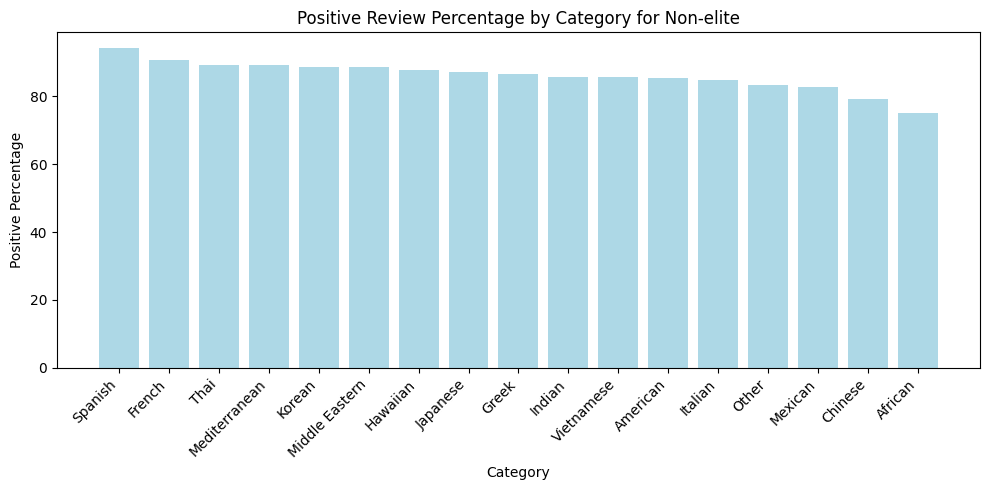

In [ ]:
data = positive_percentage_sorted.collect()

categories = [row['category'] for row in data]
positive_percentages = [row['positive_percentage'] for row in data]

# Creating the bar graph
plt.figure(figsize=(10, 5))
plt.bar(categories, positive_percentages, color='lightblue')

# Adding title and labels
plt.title('Positive Review Percentage by Category for Non-elite')
plt.xlabel('Category')
plt.ylabel('Positive Percentage')

# Rotating the x-labels for better readability
plt.xticks(rotation=45, ha='right')

# Showing the plot
plt.tight_layout()
plt.show()


In [ ]:
pivot_table1 = pivot_table.withColumn('negative_percentage', (col('negative') / col('All') * 100))

pivot_table1 = pivot_table1.filter(col('All') > 0)

negative_percentage_sorted = pivot_table1.select('category', 'negative_percentage').orderBy(col('negative_percentage').desc())
negative_percentage_sorted.show()


+--------------+-------------------+
|      category|negative_percentage|
+--------------+-------------------+
|       Chinese|  19.94240460763139|
|         Other|   16.9226750261233|
|       Mexican| 16.470269538128132|
|      American| 14.955007017254191|
|      Japanese| 14.408528198074277|
|       Italian|  14.26561125769569|
|         Greek| 14.117647058823529|
|        Indian| 14.020857473928158|
|      Hawaiian| 13.220338983050848|
|    Vietnamese| 12.947658402203857|
|Middle Eastern| 12.931034482758621|
|          Thai| 12.601626016260163|
|        Korean| 12.032085561497325|
| Mediterranean| 10.163204747774481|
|       African|  9.523809523809524|
|        French|  9.290953545232274|
|       Spanish| 6.1946902654867255|
+--------------+-------------------+



In [ ]:
from pyspark.sql.functions import col, avg

average_rating = non_elite_users_df.groupBy('category').agg(avg('stars').alias('avg_rating'))
average_rating = average_rating.orderBy(col('avg_rating').desc())

# Show the calculated average ratings
average_rating.show()


+--------------+------------------+
|      category|        avg_rating|
+--------------+------------------+
|       African|               4.5|
|       Spanish| 4.243523316062176|
| Mediterranean| 4.119918699186992|
|Middle Eastern| 4.098591549295775|
|        French|4.0261136712749614|
|         Greek|3.9836065573770494|
|          Thai| 3.980213089802131|
|      Hawaiian|3.9776119402985075|
|      Japanese|3.8632240055826936|
|    Vietnamese| 3.825174825174825|
|        Korean| 3.811715481171548|
|        Indian| 3.794478527607362|
|       Italian|3.6838407494145198|
|      American| 3.674545094936709|
|         Other|3.6514036182158454|
|       Mexican|3.6085219707057257|
|       Chinese|3.4353954581049333|
+--------------+------------------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,explode



+--------------------+-------------+---------+--------+
|      filtered_words|     polarity|sentiment|category|
+--------------------+-------------+---------+--------+
|[took, employees,...|-1.4705882E-4| Negative| Chinese|
|[yelping, food, c...|-0.0017857143| Negative| Chinese|
|[get, chinese, ch...|-0.0032051282| Negative| Chinese|
+--------------------+-------------+---------+--------+
only showing top 3 rows



In [ ]:
negative_non_elite = non_elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "American") )

American_ne_df = negative_non_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

American_ne_df.show(3, truncate=False)


+--------------------------------------------------------+--------+
|filtered_words                                          |polarity|
+--------------------------------------------------------+--------+
|[disgusted, take, restaurant.]                          |-1.0    |
|[go, here!!, worst, restaurant, experience, ever, had!!]|-1.0    |
|[horrible!!!]                                           |-1.0    |
+--------------------------------------------------------+--------+
only showing top 3 rows



In [ ]:
# Filter the DataFrame for negative sentiment and "Chinese" category
negative_non_elite = non_elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Chinese") )

chinese_ne_df = negative_non_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

chinese_ne_df.show(3,truncate=False)

#mexican, american, Japense, Italian

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|filtered_words                                                                                                                                                                |polarity|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|[worst, food, ever, today!]                                                                                                                                                   |-1.0    |
|[awful, awful, experience]                                                                                                                                                    |-1.0    |
|[terrible, service., ordered, take, took, hour, get, food, told, 15, 

In [ ]:
negative_non_elite = non_elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Japanese") )

Japanese_ne_df = negative_non_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

Japanese_ne_df.show(3, truncate=False)


+----------------------------------+--------+
|filtered_words                    |polarity|
+----------------------------------+--------+
|[one, worst, places, ever, ramen.]|-1.0    |
|[terrible, service!!]             |-1.0    |
|[worst, ramen, ever, had.]        |-1.0    |
+----------------------------------+--------+
only showing top 3 rows



In [ ]:
negative_non_elite = non_elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Mediterranean") )

Mediterranean_ne_df = negative_non_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

Mediterranean_ne_df.show(3, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|filtered_words                                                                                                                                                                                                                                                                                                                                                                                                          |polarity   |
+---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
negative_non_elite = non_elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Vietnamese") )

Vietnamese_ne_df = negative_non_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

Vietnamese_ne_df.show(3, truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|filtered_words                                                                                                                                                                                 |polarity|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|[terrible.]                                                                                                                                                                                    |-1.0    |
|[place, terrible, service., waiting, 20, minutes, nobody, came, order., come, place.]                                                                                                      

In [ ]:
negative_non_elite = non_elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Greek") )

Greek_ne_df = negative_non_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

Greek_ne_df.show(3, truncate=False)


+-------------------------------------------------------------------------------+--------+
|filtered_words                                                                 |polarity|
+-------------------------------------------------------------------------------+--------+
|[one, worst, dining, experiences, ever, even, get, eat, food.]                 |-1.0    |
|[blech....]                                                                    |-0.8    |
|[service, bad., respectful, all., also,, food, quality, bad, comparing, price.]|-0.69   |
+-------------------------------------------------------------------------------+--------+
only showing top 3 rows



In [ ]:
negative_non_elite = non_elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Indian") )

Indian_ne_df = negative_non_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

Indian_ne_df.show(3, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|filtered_words                                                                                                                                                           |polarity  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|[place, terrible., pittsburgh, know, make, food, correct,, let, alone, complexity, indian, cuisine., , city, dumpster, eastern, u.s., , go, here,, ever, go, pittsburgh.]|-1.0      |
|[kitchen, smells, real, bad., din't, feel, like, eating, food, smelling, kitchen, way, restaurant's, restrooms.]                                                         |-1.0      |
|[horrible, food, worst, customer, service.ordered, thali, tasteless, looked, like, t

In [ ]:
negative_non_elite = non_elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Italian") )

Italian_ne_df = negative_non_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

Italian_ne_df.show(3, truncate=False)


+---------------------------------------+--------+
|filtered_words                         |polarity|
+---------------------------------------+--------+
|[stay, away, dont, want, get, sick!!]  |-1.0    |
|[pizza, huts, food, takes, like, crap!]|-1.0    |
|[zero, stars., awful!]                 |-1.0    |
+---------------------------------------+--------+
only showing top 3 rows



In [ ]:
negative_non_elite = non_elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Mexican") )

Mexican_ne_df = negative_non_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

Mexican_ne_df.show(3, truncate=False)


+-----------------------------------------------------------------------------------------------------+--------+
|filtered_words                                                                                       |polarity|
+-----------------------------------------------------------------------------------------------------+--------+
|[probably, worst, talk, ever, to., manager, anthony, horrible., please, come, family, sake]          |-1.0    |
|[food, salty, service, terrible., chip, guys, servers., seems, like, everyone, waiter, assisted, us.]|-1.0    |
|[place, awful...]                                                                                    |-1.0    |
+-----------------------------------------------------------------------------------------------------+--------+
only showing top 3 rows



In [ ]:
restaurants_reviews_final.unpersist()
review.unpersist()


DataFrame[review_id: string, user_id: string, business_id: string, stars: string, date: string, text: string, useful: string, funny: string, cool: string]

In [40]:
elite_users_df = restaurants_reviews_final.filter(col("is_elite") == 1)


In [42]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

from pyspark.ml import Pipeline

from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF


# Tokenize text
tokenizer = Tokenizer(inputCol="text", outputCol="words")

# Remove stop words
stopWordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# Hashing TF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures")

# IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Build pipeline
pipeline = Pipeline(stages=[tokenizer, stopWordsRemover, hashingTF, idf])

# Fit pipeline to data
model = pipeline.fit(elite_users_df)

# Transform data
resultelite = model.transform(elite_users_df)

# Show results
resultelite.select("filtered_words", "features").show(truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [43]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from textblob import TextBlob


def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def classify_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

polarity_udf = udf(get_polarity, FloatType())
classify_sentiment_udf = udf(classify_sentiment, StringType())

df_with_polarity = resultelite.withColumn("polarity", polarity_udf(resultelite["text"]))
df_classified_elite = df_with_polarity.withColumn("sentiment", classify_sentiment_udf(df_with_polarity["polarity"]))

df_classified_elite.show()


+--------------------+--------------------+--------+--------+--------------------+-----+----------+--------------------+------+-----+----+--------+------------+--------------------+--------------------+--------------------+--------------------+-----------+---------+
|             user_id|         business_id|category|avg_star|           review_id|stars|      date|                text|useful|funny|cool|is_elite|is_not_elite|               words|      filtered_words|         rawFeatures|            features|   polarity|sentiment|
+--------------------+--------------------+--------+--------+--------------------+-----+----------+--------------------+------+-----+----+--------+------------+--------------------+--------------------+--------------------+--------------------+-----------+---------+
|BxNBl3VrzLBAkwpJ3...|gTlDDzDEHyDQ6iwjN...|  Indian|     4.5|cpI040LIhpyJRKqSI...|    1|2014-07-09|This place is hor...|  NULL| NULL|NULL|       1|           0|[this, place, is,...|[place, horrible,.

In [ ]:
elite_users_df = df_classified_elite.dropDuplicates(['text'])


In [ ]:
from pyspark.sql.functions import col, sum as _sum, lit


# Pivot table with counts, and fill NA/Null values with 0
pivot_table = elite_users_df.groupBy('category').pivot('sentiment').count().na.fill(0)

# Add 'All' column for total counts and 'positive_percentage' in one transformation to avoid multiple passes
pivot_table = pivot_table.withColumn('All', col('positive') + col('negative')) \
                         .withColumn('positive_percentage', (col('positive') / (col('positive') + col('negative')) * 100))

# Filter out categories with no reviews to avoid division by zero errors
pivot_table = pivot_table.filter(col('All') > 0)

positive_percentage_sorted1 = pivot_table.select('category', 'positive_percentage').orderBy(col('positive_percentage').desc())

positive_percentage_sorted1.show()


+--------------+-------------------+
|      category|positive_percentage|
+--------------+-------------------+
|        French|  92.53731343283582|
|      Hawaiian|  92.15686274509804|
|       Spanish|  90.47619047619048|
|          Thai|  88.51851851851852|
|       Italian|  88.17204301075269|
|       Mexican|  87.91064388961892|
|         Other|  87.69700050838841|
|      American|   87.2861165258826|
|      Japanese|  86.72032193158954|
|        Indian|  86.66666666666667|
|        Korean|  86.27450980392157|
|    Vietnamese|  84.55882352941177|
| Mediterranean|  84.54106280193237|
|       Chinese|  84.47937131630648|
|         Greek|   82.6086956521739|
|Middle Eastern|  81.81818181818183|
|       African|               75.0|
+--------------+-------------------+



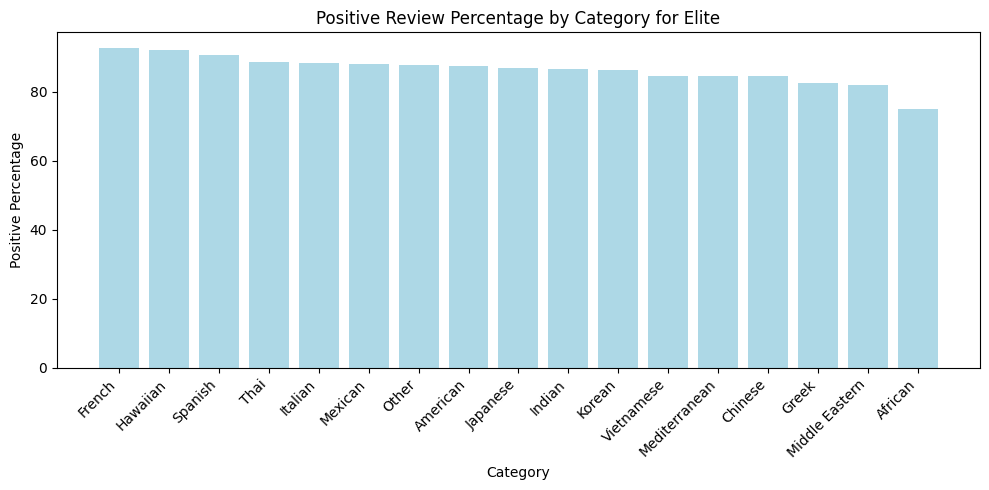

In [ ]:
data = positive_percentage_sorted1.collect()

# Creating lists of categories and their corresponding positive percentages
categories = [row['category'] for row in data]
positive_percentages = [row['positive_percentage'] for row in data]

# Creating the bar graph
plt.figure(figsize=(10, 5))
plt.bar(categories, positive_percentages, color='lightblue')

# Adding title and labels
plt.title('Positive Review Percentage by Category for Elite')
plt.xlabel('Category')
plt.ylabel('Positive Percentage')

# Rotating the x-labels for better readability
plt.xticks(rotation=45, ha='right')

# Showing the plot
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql.functions import col, avg

# Calculate the average rating for each category, rounded to 2 decimal places
average_rating_elite = elite_users_df.groupBy('category').agg(avg('stars').alias('avg_rating_elite'))
average_rating_elite = average_rating_elite.orderBy(col('avg_rating_elite').desc())

# Show the calculated average ratings
average_rating_elite.show()


+--------------+------------------+
|      category|  avg_rating_elite|
+--------------+------------------+
|      Hawaiian| 4.172413793103448|
|        French| 4.098092643051771|
|       African|               4.0|
|Middle Eastern| 3.942857142857143|
| Mediterranean|3.9363636363636365|
|       Spanish| 3.883720930232558|
|        Korean| 3.830357142857143|
|       Italian|3.8161434977578477|
|          Thai| 3.811387900355872|
|      Japanese| 3.804469273743017|
|      American|3.7953867568104993|
|         Other| 3.787672838059527|
|        Indian|3.7818181818181817|
|       Mexican|3.6630434782608696|
|         Greek|              3.64|
|    Vietnamese|              3.62|
|       Chinese| 3.546112115732369|
+--------------+------------------+



In [ ]:
negative_elite = elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Chinese"))

chinese_e_df = negative_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

chinese_e_df.show(3,truncate=False)

#mexican, Indian, Greek, Vietnamese

+----------------------------------------------------------------------------------------------------------------+--------+
|filtered_words                                                                                                  |polarity|
+----------------------------------------------------------------------------------------------------------------+--------+
|[checked, yelp, reviews, went, noodle, shop, mandalay, bay., , , absolutely, terrible., , favor, go, elsewhere.]|-1.0    |
|["before, ordering,, looked, reviews, doubtful., friends, decided, ""what, hell]                                |-0.8    |
|[friend, ate, lunch, head, airport., something, rave, forever, day., bad, either.]                              |-0.7    |
+----------------------------------------------------------------------------------------------------------------+--------+
only showing top 3 rows



In [ ]:
negative_elite = elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Indian"))

Indian_e_df = negative_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

Indian_e_df.show(3,truncate=False)



+---------------------------------------------------------------------------------------------------------------------------------+--------+
|filtered_words                                                                                                                   |polarity|
+---------------------------------------------------------------------------------------------------------------------------------+--------+
|[place, horrible,, come, here!!!]                                                                                                |-1.0    |
|[butter, chicken!]                                                                                                               |-0.75   |
|[so,, came, cafe, tandoor, group,, lamb, biryani,, piratha,, naan,, saag, paneer,, chicken, tikka, maasala,, okra, based, curry.]|-0.6    |
+---------------------------------------------------------------------------------------------------------------------------------+--------+
only showing 

In [ ]:
negative_elite = elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Greek"))

Greek_e_df = negative_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

Greek_e_df.show(3,truncate=False)



+----------------------------------------------------------------------------------------------------+--------+
|filtered_words                                                                                      |polarity|
+----------------------------------------------------------------------------------------------------+--------+
|[$11, chicken, kabob, plate,, holy, smokes!, vegas, even, food, court.]                             |-0.75   |
|[wow, expensive, !]                                                                                 |-0.2625 |
|[came, looking, stellar, reviews, place, had., somewhat, disappointed, hence, giving, three, stars.]|-0.25   |
+----------------------------------------------------------------------------------------------------+--------+
only showing top 3 rows



In [ ]:
negative_elite = elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Vietnamese"))

Vietnamese_e_df = negative_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

Vietnamese_e_df.show(3,truncate=False)



+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|filtered_words                                                                                                                                                                                            |polarity|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|[omg., place, awful., sorry..]                                                                                                                                                                            |-0.75   |
|[randomly, craved, pho, staying, treasure, island, hotel., 24, hr, place,, 1, star, that.]                                                     

In [ ]:
negative_elite = elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Mediterranean"))

Mediterranean_e_df = negative_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

Mediterranean_e_df.show(3,truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|filtered_words                                                                                                                                        |polarity|
+------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|["came, zorba's, suggestion, cousin, has,, quote,, ""never, given, bad, food, recommendation"".]                                                      |-0.7    |
|[woww!, , , order:, , chicken, schwarma, side, hummus, pita., , , order, falafel., cucumber, drink., , side, garlic, sauce., , side, cucumber, sauce.]|-0.6    |
|[deplorable, service.]                                                                                                                                |-0.6    |
+---------------------------

In [ ]:
negative_elite = elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Mexican"))

Mexican_e_df = negative_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

Mexican_e_df.show(3,truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|filtered_words                                                                                                                                                                                     |polarity|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|[horrible, experience., took, table, 2, hours, order,, get, food, pay., two, tacos, oily, nothing, rave, about., even, messed, order,, leaving, side, dish, charging, it., water, never, refilled.]|-1.0    |
|[#obsessed!!!!]                                                                                                                                                            

In [ ]:
negative_elite = elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Italian"))

Italian_e_df = negative_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

Italian_e_df.show(3,truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|filtered_words                                                                                                                                     |polarity|
+---------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|[shame, place, terrible, review, service, food, received, pizza, hut, always, highest, expectations.]                                              |-1.0    |
|[worst, buca, history, buca, di, beppo!]                                                                                                           |-1.0    |
|[wolfgang, puck...isnt, suppose, outrageous, mastermind, chef., recipes, exploding, flavor?, dint, know, think, might, missed, something, pressed.]|-1.0    |
+---------------------------------------------

In [ ]:
negative_elite = elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "American"))

American_e_df = negative_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

American_e_df.show(3,truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------+--------+
|filtered_words                                                                                                                                 |polarity|
+-----------------------------------------------------------------------------------------------------------------------------------------------+--------+
|[damn, food, disgusting., night, drinking, clubbin, xs...]                                                                                     |-1.0    |
|[horrible!]                                                                                                                                    |-1.0    |
|[desserts, terrible,, see,, start, here?, , nevermind,, like, 28-30, bucks, each,, 10, split, and,, and,, and,, ah, forget, it,, bother.......]|-1.0    |
+---------------------------------------------------------------------

In [ ]:
negative_elite = elite_users_df.filter((col("sentiment") == "Negative") & (col("category") == "Japanese"))

Japanese_e_df = negative_elite.orderBy(col("polarity").asc()).select("filtered_words", "polarity")

Japanese_e_df.show(3,truncate=False)


+----------------------------------------------------------------------------------------------------------+--------+
|filtered_words                                                                                            |polarity|
+----------------------------------------------------------------------------------------------------------+--------+
|[visited, saturday, night., , one, worst, dining, experiences, pittsburgh, since, moving, 8, months, ago.]|-1.0    |
|[awful, experience.]                                                                                      |-1.0    |
|[shying, away, fuji, seemed, like, chain....that, stupid, decision.]                                      |-1.0    |
+----------------------------------------------------------------------------------------------------------+--------+
only showing top 3 rows



Recommendations from Elite Users & Non-Elite Users

In [ ]:
import pandas as pd


extracted_text = [
    'Chinese', 'checked, yelp, reviews, went, noodle, shop, mandalay, bay, absolutely, terrible, favor, go, elsewhere.',
    'Indian', 'place, horrible, cafe, tandoor, group, lamb, biryani, piratha, naan, saag, paneer, chicken tikka maasala, okra, curry',
    'Greek', '$11, chicken, kabob, plate, holy smokes!, vegas, even, food, court, expensive, came, looking, reviews, disappointed, three, stars',
    'Vietnamese', 'omg., place, awful, randomly, craved, pho, staying, treasure, island, hotel, 24, hr, place, 1, star, stumbled, wrong, turn, stuck, evil, creek, rush, hour, saw, place, thought, kill, time, asian, grocery, store.',
    'Mediterranean', 'came, zorba\'s, suggestion, cousin, never, bad, recommendation, chicken, schwarma, hummus, pita, falafel, cucumber, drink, garlic sauce, cucumber sauce, deplorable, service',
    'Mexican', 'horrible, experience, table, hours, order, food, pay, two, tacos, oily, nothing, rave, order, messed, side dish, charging, water, never, refilled',
    'Italian', 'shame, place, terrible, review, service, food, pizza hut, expectations, worst, buca, history, buca di beppo, wolfgang puck, flavor, might, missed, pressed',
    'American', 'damn, food, disgusting, night, drinking, clubbing, horrible, desserts, terrible, 28-30, bucks, each, 10, split, forget, it',
    'Japanese', 'visited, saturday, night, worst, dining, experiences, pittsburgh, since, moving, months, awful, experience, shying, fuji, chain, decision'
]

# Pairing cuisine types with their respective reviews
data = {
    'Cuisine': extracted_text[0::2],
    'Review': extracted_text[1::2]
}

# Creating a dataframe
df_reviews = pd.DataFrame(data)
df_reviews


,Cuisine,Review
0,Chinese,"checked, yelp, reviews, went, noodle, shop, ma..."
1,Indian,"place, horrible, cafe, tandoor, group, lamb, b..."
2,Greek,"$11, chicken, kabob, plate, holy smokes!, vega..."
3,Vietnamese,"omg., place, awful, randomly, craved, pho, sta..."
4,Mediterranean,"came, zorba's, suggestion, cousin, never, bad,..."
5,Mexican,"horrible, experience, table, hours, order, foo..."
6,Italian,"shame, place, terrible, review, service, food,..."
7,American,"damn, food, disgusting, night, drinking, clubb..."
8,Japanese,"visited, saturday, night, worst, dining, exper..."


•	Chinese: Reviews suggest that the flavour should be enhanced.
•	Indian: Place/Ambiance should be upgraded.
•	Greek: It appears that pricing and value for money were considered. Hence the necessity to locate Balance between price and quality.
•	Mediterranean: The review indicates a service issue.
•	Mexican: Given the complaint about the oily tacos and delayed service.
•	Italian: Food quality in terms of flavour and service requires improvement.
•	American: The food and drinks do not meet the expectations. Need to rethink their price as well.
•	Japanese: Need to maintain consistency across the food chain.


For Non-elite

In [ ]:

extracted_text = [
    'Chinese', 'worst, food, ever, today,awful, awful, experience,terrible, service., ordered, take, took, hour, get, food, told, 15, minutes., get, store, greeted, anything, checking, split, ends, cell, phone., never, go, again.',
    'Indian', 'place, terrible., pittsburgh, know, make, food, correct,, let, alone, complexity, indian, cuisine., , city, dumpster, eastern, u.s., , go, here,, ever, go, pittsburgh.,kitchen, smells, real, bad., dint, feel, like, eating, food, smelling, kitchen, restrooms.,horrible, food, worst, customer, service.ordered, thali, tasteless, looked, like, two, days, old.please, favor, visiting, place.',
    'Greek', 'one, worst, dining, experiences, ever, even, get, eat, food,blech.,service, bad., respectful, all., also,, food, quality, bad, comparing, price',
    'Vietnamese', 'terrible..place, terrible, service., waiting, 20, minutes, nobody,came, visit, decided, take, sunday, lunch., place, closest, house, decided, go, here., pulled, remembered, came, hated, it., decided, order, something, diff, food, tasted, terrible',
    'Mediterranean', 'ven, close, lebanese, food, impressing, words, explain, bad, experience, worst, ever,wish, stars, service, food, separately, hate, give, 2, stars, place, like,, service, today, just...ugh.,"the, worst, ever, tasted, among, mediterranean, food., horrible, taste., ordered, combo, platter, falafel, wrap., close, requested, take, to-go., took, food, home, tasted, horrible, food, ever., fries, salt, tasted, like, crap., worst, part, given, filet, wrap, instead, falafel, wrap., even, eat, meat, clearly, mentioned, ""elahe""., yet, food, got, meat, combo, well, wrap., drove, 30mins, messed, up.',
    'Mexican', 'probably, worst, talk, ever, to., manager, anthony, horrible., please, come, family, sake,food, salty, service, terrible., chip, guys, servers., seems, like, everyone, waiter, assisted, awful',
    'Italian', 'stay, away, dont, want, get, sick,pizza, huts, food, takes, like, crap,zero, stars, awful',
    'American', 'disgusted, take, worst, restaurant, experience, ever, horrible',
    'Japanese', 'one, worst, places, ever, ramen,terrible, service!!'
]

# Pairing cuisine types with their respective reviews
data = {
    'Cuisine': extracted_text[0::2],
    'Review': extracted_text[1::2]
}

# Creating a dataframe
df_reviews = pd.DataFrame(data)
df_reviews


,Cuisine,Review
0,Chinese,"worst, food, ever, today,awful, awful, experie..."
1,Indian,"place, terrible., pittsburgh, know, make, food..."
2,Greek,"one, worst, dining, experiences, ever, even, g..."
3,Vietnamese,"terrible..place, terrible, service., waiting, ..."
4,Mediterranean,"ven, close, lebanese, food, impressing, words,..."
5,Mexican,"probably, worst, talk, ever, to., manager, ant..."
6,Italian,"stay, away, dont, want, get, sick,pizza, huts,..."
7,American,"disgusted, take, worst, restaurant, experience..."
8,Japanese,"one, worst, places, ever, ramen,terrible, serv..."


Recommendations Analysing Non-	Elite Users group reviews:
•	Chinese: serve fresh, authentic food that has a reputation for providing good customer service and timely order fulfilment.
•	Indian: create a modern and clean atmosphere with an authentic food, is known for employing fresh ingredients, and provides friendly hospitality.
•	Greek: The cost-quality ratio is favourable. It should serve authentic cuisine such as moussaka, souvlaki, and fresh Greek salads.
•	Vietnamese: prompt and attentive service.
•	Mediterranean: Includes shawarma, kebabs, and mezes. Provide friendly service and the ability to accommodate dietary demands (such as vegetarian or vegan alternatives).
•	Mexican: uses fresh ingredients and has a less greasy cuisine. Provide rapid service and, possibly, a unique twist on typical Mexican food.
•	Italian: cuisine features homemade pasta and pizza cooked with high-quality ingredients. It should have a nice atmosphere and be known for providing friendly and efficient service.
•	American: Is known for its comfortable, hearty meals and welcoming atmosphere. It should have a diversified cuisine that caters to a wide range of preferences, as well as a reputation for excellent late-night dining.
•	Japanese: Is well-known for its sushi and sashimi, stressing freshness and quality of the seafood, as well as a calm and courteous dining experience.
